In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from scipy import stats 

import missingno as msno 
plt.style.use('seaborn') 

import warnings 
warnings.filterwarnings("ignore") 

mpl.rcParams['axes.unicode_minus'] = False 

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv", parse_dates = ["datetime"]) 
df_test = pd.read_csv("test.csv", parse_dates = ["datetime"])

In [3]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour

df_test["year"] = df_test["datetime"].dt.year 
df_test["month"] = df_test["datetime"].dt.month 
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

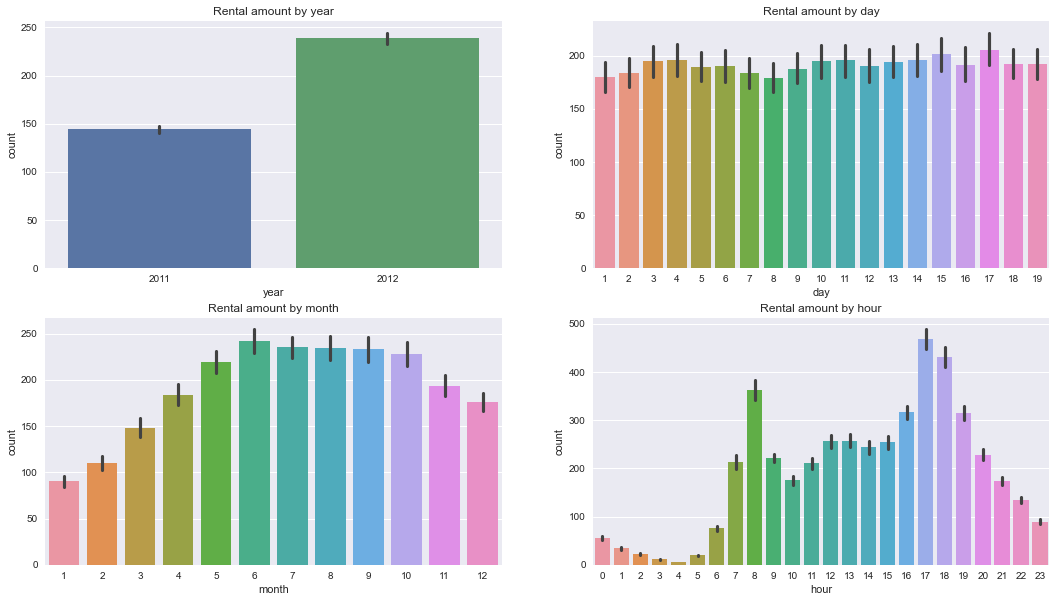

In [4]:
figure, ((ax1,ax3),(ax2,ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(18,10)

sns.barplot(data=df_train, x = "year", y = "count", ax = ax1) 
sns.barplot(data=df_train, x = "month", y = "count", ax = ax2) 
sns.barplot(data=df_train, x = "day", y = "count", ax = ax3)
sns.barplot(data=df_train, x = "hour", y = "count", ax = ax4)

ax1.set(ylabel = "count", title = "Rental amount by year") 
ax2.set(ylabel = "count", title = "Rental amount by month") 
ax3.set(ylabel = "count", title = "Rental amount by day")
ax4.set(ylabel = "count", title = "Rental amount by hour")

In [5]:
df_train["dayofweek"] = df_train["datetime"].dt.dayofweek
df_test["dayofweek"] = df_test["datetime"].dt.dayofweek
#요일 변수 추가생성

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
df_train_wind_0 = df_train.loc[df_train['windspeed'] == 0]
df_train_wind_Not_0 = df_train.loc[df_train['windspeed'] != 0]

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
def predict_windspeed(data):
    data_Wind_0 = data.loc[data['windspeed'] == 0]
    data_Wind_Not_0 = data.loc[data['windspeed'] != 0]
    
    corr_windspeed = ['season', 'weather', 'day', 'temp', 'atemp', 'humidity']
    #풍속이 날씨에 대한 변수기 때문에 날씨에 관련된 변수들을 독립변수로 사용
    
    data_Wind_Not_0['windspeed'] = data_Wind_Not_0['windspeed'].astype('str')
    #data_wind_not_0 windspeed 타입을 str로 변환
    
    model = RandomForestClassifier(n_estimators=100)
    #n_estimator - 결정트리 수
    
    model.fit(data_Wind_Not_0[corr_windspeed], data_Wind_Not_0['windspeed'])
    #training data set 학습
    
    wind_predict = model.predict(data_Wind_0[corr_windspeed])
    
    predict_wind_0 = data_Wind_0
    predict_wind_not_0 = data_Wind_Not_0
    
    predict_wind_0['windspeed'] = wind_predict
    #windspeed = 0 인 값에 예측된 데이터 저장
    
    data = predict_wind_not_0.append(predict_wind_0)
    #predict_wind_not_0에 windspeed를 예측해서 채워 넣은 column을 추가
    
    data['windspeed'] = data['windspeed'].astype('float')
    #다시 float타입으로 변경
    data.reset_index(inplace = True)
    data.drop('index', inplace = True, axis = 1)
    
    return data
    
    

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

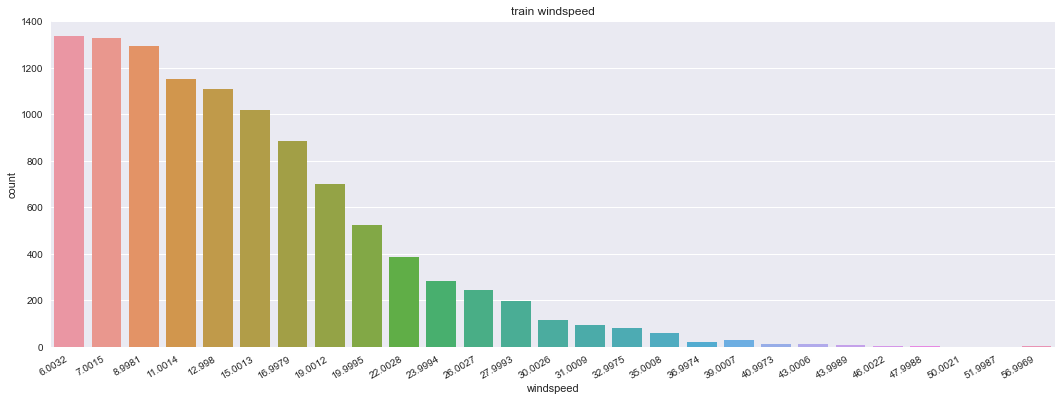

In [10]:
df_train = predict_windspeed(df_train)
df_test = predict_windspeed(df_test)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=df_train, x="windspeed", ax=ax1)

In [11]:
feature_names = ['season','weather', 'temp', 'atemp', 'humidity', 'windspeed',
                 'year', 'hour', 'dayofweek', 'holiday', 'workingday']

In [12]:
X_train = df_train[feature_names]
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [13]:
X_test = df_test[feature_names]
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
2,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
3,1,1,9.84,11.365,60,15.0013,2011,5,3,0,1
4,1,1,9.02,10.605,60,15.0013,2011,6,3,0,1


In [14]:
y_train = df_train['count']

In [21]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [25]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, n_jobs = -1, random_state=5)

In [26]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: total: 3.08 s
Wall time: 10.3 s
Score= 0.33019


In [27]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=5)

In [28]:
prediction_rdf = model.predict(X_test)

print(prediction_rdf.shape)
prediction_rdf[0:10]

(6493,)


array([ 12.09,   3.64,   3.02,   6.84,  37.71, 107.4 , 239.09, 135.16,
        61.72,  63.79])

[Text(0.5, 1.0, 'test')]

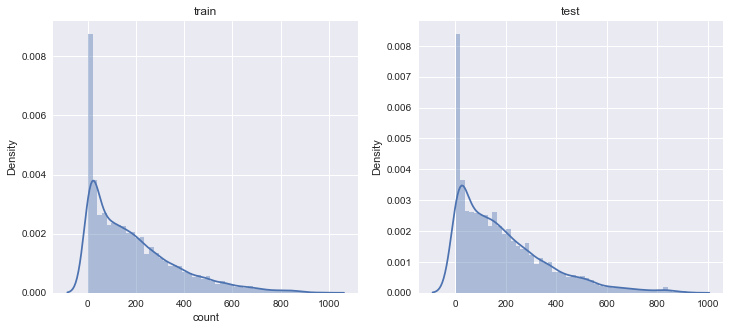

In [29]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(prediction_rdf,ax=ax2,bins=50)
ax2.set(title="test")

In [30]:
submission = pd.read_csv("sampleSubmission.csv",parse_dates=['datetime'])
submission

submission['count'] = prediction_rdf

submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.09
1,2011-01-20 01:00:00,3.64
2,2011-01-20 02:00:00,3.02
3,2011-01-20 03:00:00,6.84
4,2011-01-20 04:00:00,37.71


In [31]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)

OSError: Cannot save file into a non-existent directory: 'data'